# Как построить географическую карту с помощью я зыка программирования Python

## Способ первый. Basemap

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Внимание! Basemap по умолчанию не входит в Anaconda Python Distribution

Решение: Установим вручную с помощью пакетного менеджера conda.

Как?

1. Запускаем терминал (Ctrl+Alt+T)
2. В командной строке набираем: conda install basemap

Переходим к следующему шагу только после установки Basemap

In [2]:
from mpl_toolkits.basemap import Basemap

%matplotlib inline

In [4]:
f = open("../Week3/usgs431.txt", 'r')

basin_id = []
basin_long = []
basin_lat = []
basin_area = []
for line in f:
    s = line.split()
    basin_id.append(s[0])
    basin_long.append(s[1])
    basin_lat.append(s[2])
    basin_area.append(s[3])

# Создаем рабочий DataFrame
basin_list = pd.DataFrame({'ID': basin_id, 
                           'long': basin_long, 
                           'lat': basin_lat, 
                           'area': basin_area})

basin_list['long'] = pd.to_numeric(basin_list['long'], errors='coerce')
basin_list['lat'] = pd.to_numeric(basin_list['lat'], errors='coerce')
basin_list['area'] = pd.to_numeric(basin_list['area'], errors='coerce')

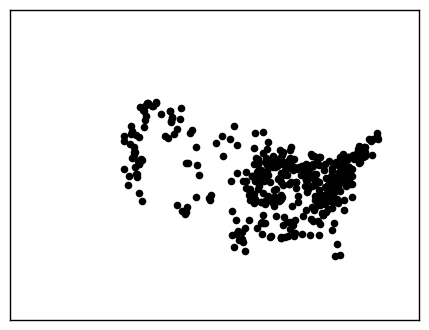

In [26]:
m = Basemap(projection='lcc', 
            lat_0 = np.mean(basin_list['lat'].values), 
            lon_0 = np.mean(basin_list['long'].values),
            llcrnrlon=-130.0, llcrnrlat=10.0,
            urcrnrlon=-50.0, urcrnrlat=60.0,
            resolution='l')

x, y = m(basin_list['long'].values, basin_list['lat'].values)

m.scatter(x,y, 
          c='black', 
          marker='o')

{-120: ([<matplotlib.lines.Line2D at 0xaaaaffec>], []),
 -80: ([<matplotlib.lines.Line2D at 0xaacaa26c>], [])}

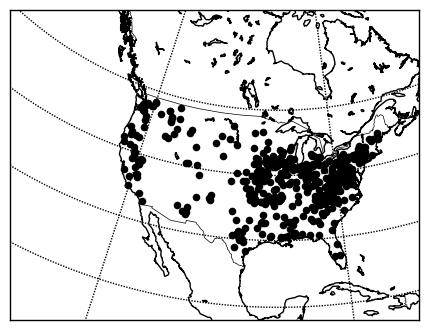

In [30]:
m = Basemap(projection='lcc', 
            lat_0 = np.mean(basin_list['lat'].values), 
            lon_0 = np.mean(basin_list['long'].values),
            llcrnrlon=-130.0, llcrnrlat=10.0,
            urcrnrlon=-50.0, urcrnrlat=60.0,
            resolution='l')

x, y = m(basin_list['long'].values, basin_list['lat'].values)

m.scatter(x,y, 
          c='red', 
          marker='o')

m.drawcoastlines()
m.drawcountries()
m.drawparallels(np.arange(20, 60, 10))
m.drawmeridians(np.arange(-120, 20, 40))

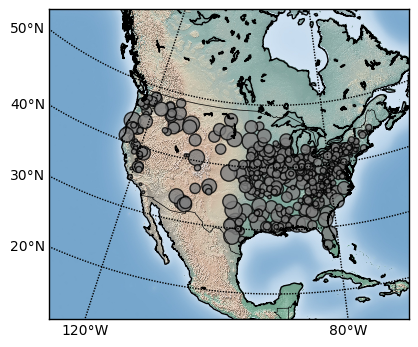

In [36]:
m = Basemap(projection='lcc', 
            lat_0 = np.mean(basin_list['lat'].values), 
            lon_0 = np.mean(basin_list['long'].values),
            llcrnrlon=-125.0, llcrnrlat=10.0,
            urcrnrlon=-50.0, urcrnrlat=60.0,
            resolution='l')

x, y = m(basin_list['long'].values, basin_list['lat'].values)

m.shadedrelief()
m.drawcoastlines()
m.drawcountries()
m.drawparallels(np.arange(20, 60, 10), labels=[1, 0, 0, 1])
m.drawmeridians(np.arange(-120, 20, 40), labels=[1, 0, 0, 1])

m.scatter(x,y, 
          s=basin_list['area']/basin_list['area'].min(),
          c='gray',
          alpha=0.8
         )

In [37]:
#!wget ftp://ftp.cdc.noaa.gov/Datasets/udel.airt.precip/air.mon.ltm.v401.nc

--2016-12-09 11:31:27--  ftp://ftp.cdc.noaa.gov/Datasets/udel.airt.precip/air.mon.ltm.v401.nc
           => ‘air.mon.ltm.v401.nc’
Resolving ftp.cdc.noaa.gov (ftp.cdc.noaa.gov)... 140.172.38.117
Connecting to ftp.cdc.noaa.gov (ftp.cdc.noaa.gov)|140.172.38.117|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Datasets/udel.airt.precip ... done.
==> SIZE air.mon.ltm.v401.nc ... 18669596
==> PASV ... done.    ==> RETR air.mon.ltm.v401.nc ... done.
Length: 18669596 (18M) (unauthoritative)

air.mon.ltm.v401.nc 100%[===================>]  17,80M   196KB/s    in 1m 40s  

2016-12-09 11:33:10 (182 KB/s) - ‘air.mon.ltm.v401.nc’ saved [18669596]



In [38]:
from scipy.io import netcdf

nc = netcdf.netcdf_file('air.mon.ltm.v401.nc')

In [41]:
air = nc.variables['air']
lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]

In [63]:
air.actual_range

array([-70.67333221,  39.45666504], dtype=float32)

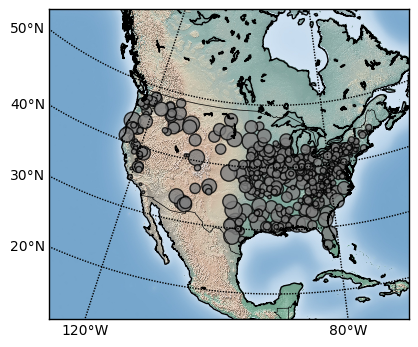

In [36]:
m = Basemap(projection='lcc', 
            lat_0 = np.mean(basin_list['lat'].values), 
            lon_0 = np.mean(basin_list['long'].values),
            llcrnrlon=-125.0, llcrnrlat=10.0,
            urcrnrlon=-50.0, urcrnrlat=60.0,
            resolution='l')

x, y = m(basin_list['long'].values, basin_list['lat'].values)

x2, y2 = m(np.meshgrid(lon,lat))

m.drawcoastlines()
m.drawcountries()
m.drawparallels(np.arange(20, 60, 10), labels=[1, 0, 0, 1])
m.drawmeridians(np.arange(-120, 20, 40), labels=[1, 0, 0, 1])

m.contour(x2, y2, )

m.scatter(x,y, 
          s=basin_list['area']/basin_list['area'].min(),
          c='gray',
          alpha=0.8
         )